In [1]:
from pyomo.environ import (ConcreteModel,
                           SolverFactory,
                           units as pyunits)

import idaes.logger as idaeslog
import pyomo.contrib.parmest.parmest as parmest

import pandas as pd
import pytest

from idaes.core import FlowsheetBlock
from idaes.generic_models.unit_models import Flash
from idaes.generic_models.properties.core.generic.generic_property import (
        GenericParameterBlock)

from idaes.core.util.model_statistics import degrees_of_freedom


def binary_params_peng(file, configuration, comp_1, comp_2, x_comp_1, x_comp_2,
    init_temp = 323.15, init_press = 399800, init_x_c1 = 0.5, init_x_c2 = 0.5,
    init_kappa_1_2 = -0.3, init_kappa_2_1 = 0.5, eps = 0.0, scaling_fac = 1e-4):
    """
    Estimates kappa parameters for Peng Robinson equation.

    Args:
        file: csv data file in Pa and K
        configuration: imported configuration dictionary
        comp_1: component 1
        comp_2: component 2
        x_comp_1: name of component 1 mole fraction column in csv file
        x_comp_2: name of component 1 mole fraction column in csv file
        init_temp = temperature to initialize model [K]
        init_press = pressure to initialize model [Pa]
        init_x_c1 = component 1 mole fraction to initialize model [mol/mol]
        init_x_c2 = component 1 mole fraction to initialize model [mol/mol]
        init_kappa_1_2 = initial guess for kappa parameter component 2-component 1
        init_kappa_2_1 = initial guess for kappa parameter component 1-component 2
        eps = extra
        scaling_fac = 1e-4)

    Returns:
        printed parameters for binary interaction parameters
    """
    data = pd.read_csv(file)

    def PR_model(data):
        """
        Function which returns initilized model.

        Args:
            data: pandas DataFrame with data

        Returns:
            initialized model
        """
        m = ConcreteModel()

        m.fs = FlowsheetBlock(default={"dynamic": False})

        m.fs.properties = GenericParameterBlock(default=configuration)

        m.fs.state_block = m.fs.properties.state_block_class(
            default={"parameters": m.fs.properties,
                     "defined_state": True})
        x = float(data[x_comp_1])+eps
        m.fs.state_block.flow_mol.fix(1)
        m.fs.state_block.temperature.fix(float(data["temperature"]))
        m.fs.state_block.pressure.fix(float(data["pressure"]))
        m.fs.state_block.mole_frac_comp[comp_2].fix(1-x)
        m.fs.state_block.mole_frac_comp[comp_1].fix(x)

        # parameter - kappa_ij (set at 0.3, 0 if i=j)
        m.fs.properties.PR_kappa[comp_2, comp_2].fix(0)
        m.fs.properties.PR_kappa[comp_2, comp_1].fix(init_kappa_2_1)
        m.fs.properties.PR_kappa[comp_1, comp_1].fix(0)
        m.fs.properties.PR_kappa[comp_1, comp_2].fix(init_kappa_1_2)

        # Initialize the flash unit
        m.fs.state_block.initialize(outlvl=idaeslog.CRITICAL)

        # Fix the state variables on the state block
        m.fs.state_block.pressure.unfix()
        m.fs.state_block.mole_frac_comp[comp_2].unfix()
        m.fs.state_block.mole_frac_comp[comp_1].unfix()
        m.fs.state_block.temperature.fix(float(data["temperature"]))
        m.fs.state_block.mole_frac_phase_comp['Liq', comp_1].fix(float(data[x_comp_1]))
        m.fs.state_block.mole_frac_phase_comp['Liq', comp_2].fix(float(data[x_comp_2]))
        m.fs.state_block.mole_frac_comp[comp_1].fix(float(data[x_comp_1])+eps)
        m.fs.state_block.mole_frac_comp[comp_2].unfix()

        # Set bounds on variables to be estimated
        m.fs.properties.PR_kappa[comp_2, comp_1].setlb(-5)
        m.fs.properties.PR_kappa[comp_2, comp_1].setub(5)

        m.fs.properties.PR_kappa[comp_1, comp_2].setlb(-5)
        m.fs.properties.PR_kappa[comp_1, comp_2].setub(5)

        # Return initialized flash model
        return m

    def SSE(m, data):
        """
        returns objective function expresion.

        Args:
            m: model
            data: pandas DataFrame with data

        Returns:
            objectuve function scaled expresion
        """
        expr = ((float(data["pressure"]) - m.fs.state_block.pressure)**2)

        return expr * scaling_fac

    variable_name = ["fs.properties.PR_kappa['" + comp_2 + "','" + comp_1 + "']",
                     "fs.properties.PR_kappa['" + comp_1 + "','" + comp_2 + "']"]

    pest = parmest.Estimator(PR_model, data, variable_name, SSE, tee=True)

    obj_value, parameters, a = pest.theta_est(calc_cov=True)

    print_params(obj_value, parameters)
    
    print(parameters)
    
#     param = pd.DataFrame.from_dict(parameters, index=[0])
    param = pd.DataFrame(parameters, index=[0])
    
    print(param)
    
#     param = pd.DataFrame.from_dict(parameters, orient='columns', 
#                                    columns=['fs.properties.PR_kappa['" + comp_2 + "','" + comp_1 + "']', 
#                                             'fs.properties.PR_kappa['" + comp_1 + "','" + comp_2 + "']'])
    
    b = pest.objective_at_theta(param)
    
    print("covariance_matrix",a)
    print("obj_theta",b)
    
    LR1= pest.likelihood_ratio_test(b, obj_value, [0.95])
    
    print(LR1)
    
#     parmest.graphics.pairwise_plot(parameters)


def print_params(obj_value, parameters):
    """
    returns printed parameters.

    Args:
        obj_value: objective function value
        parameters: estimated binary parameters

    Returns:
        printed parameters for binary interaction parameters
    """
    print("The SSE at the optimal solution is %0.6f" % obj_value)
    print()
    print("The values for the parameters are as follows:")
    for k,v in parameters.items():
        print(k, "=", v)

class Data_reg:

    def __init__(self, configuration, comp_1, comp_2, x_comp_1, x_comp_2):
        self.configuration = configuration
        self.comp_1 = comp_1
        self.comp_2 = comp_2
        self.x_comp_1 = x_comp_1
        self.x_comp_2 = x_comp_2

        
def binary_params_peng(file, configuration, comp_1, comp_2, x_comp_1, x_comp_2,
    init_temp = 323.15, init_press = 399800, init_x_c1 = 0.5, init_x_c2 = 0.5,
    init_kappa_1_2 = -0.3, init_kappa_2_1 = 0.5, eps = 0.0, scaling_fac = 1e-4):
    """
    Estimates kappa parameters for Peng Robinson equation.

    Args:
        file: csv data file in Pa and K
        configuration: imported configuration dictionary
        comp_1: component 1
        comp_2: component 2
        x_comp_1: name of component 1 mole fraction column in csv file
        x_comp_2: name of component 1 mole fraction column in csv file
        init_temp = temperature to initialize model [K]
        init_press = pressure to initialize model [Pa]
        init_x_c1 = component 1 mole fraction to initialize model [mol/mol]
        init_x_c2 = component 1 mole fraction to initialize model [mol/mol]
        init_kappa_1_2 = initial guess for kappa parameter component 2-component 1
        init_kappa_2_1 = initial guess for kappa parameter component 1-component 2
        eps = extra
        scaling_fac = 1e-4)

    Returns:
        printed parameters for binary interaction parameters
    """
    data = pd.read_csv(file)

    def PR_model(data):
        """
        Function which returns initilized model.

        Args:
            data: pandas DataFrame with data

        Returns:
            initialized model
        """
        m = ConcreteModel()

        m.fs = FlowsheetBlock(default={"dynamic": False})

        m.fs.properties = GenericParameterBlock(default=configuration)

        m.fs.state_block = m.fs.properties.state_block_class(
            default={"parameters": m.fs.properties,
                     "defined_state": True})
        x = float(data[x_comp_1])+eps
        m.fs.state_block.flow_mol.fix(1)
        m.fs.state_block.temperature.fix(float(data["temperature"]))
        m.fs.state_block.pressure.fix(float(data["pressure"]))
        m.fs.state_block.mole_frac_comp[comp_2].fix(1-x)
        m.fs.state_block.mole_frac_comp[comp_1].fix(x)

        # parameter - kappa_ij (set at 0.3, 0 if i=j)
        m.fs.properties.PR_kappa[comp_2, comp_2].fix(0)
        m.fs.properties.PR_kappa[comp_2, comp_1].fix(init_kappa_2_1)
        m.fs.properties.PR_kappa[comp_1, comp_1].fix(0)
        m.fs.properties.PR_kappa[comp_1, comp_2].fix(init_kappa_1_2)

        # Initialize the flash unit
        m.fs.state_block.initialize(outlvl=idaeslog.CRITICAL)

        # Fix the state variables on the state block
        m.fs.state_block.pressure.unfix()
        m.fs.state_block.mole_frac_comp[comp_2].unfix()
        m.fs.state_block.mole_frac_comp[comp_1].unfix()
        m.fs.state_block.temperature.fix(float(data["temperature"]))
        m.fs.state_block.mole_frac_phase_comp['Liq', comp_1].fix(float(data[x_comp_1]))
        m.fs.state_block.mole_frac_phase_comp['Liq', comp_2].fix(float(data[x_comp_2]))
        m.fs.state_block.mole_frac_comp[comp_1].fix(float(data[x_comp_1])+eps)
        m.fs.state_block.mole_frac_comp[comp_2].unfix()

        # Set bounds on variables to be estimated
        m.fs.properties.PR_kappa[comp_2, comp_1].setlb(-5)
        m.fs.properties.PR_kappa[comp_2, comp_1].setub(5)

        m.fs.properties.PR_kappa[comp_1, comp_2].setlb(-5)
        m.fs.properties.PR_kappa[comp_1, comp_2].setub(5)

        # Return initialized flash model
        return m

    def SSE(m, data):
        """
        returns objective function expresion.

        Args:
            m: model
            data: pandas DataFrame with data

        Returns:
            objectuve function scaled expresion
        """
        expr = ((float(data["pressure"]) - m.fs.state_block.pressure)**2)

        return expr * scaling_fac

    variable_name = ["fs.properties.PR_kappa['" + comp_2 + "','" + comp_1 + "']",
                     "fs.properties.PR_kappa['" + comp_1 + "','" + comp_2 + "']"]

    pest = parmest.Estimator(PR_model, data, variable_name, SSE, tee=True)

    obj_value, parameters, a = pest.theta_est(calc_cov=True)
    
def binary_params_peng2(file, configuration, comp_1, comp_2, x_comp_1, x_comp_2,
init_temp = 323.15, init_press = 399800, init_x_c1 = 0.5, init_x_c2 = 0.5,
init_kappa_1_2 = -0.3, init_kappa_2_1 = 0.5, eps = 0.0, scaling_fac = 1e-4):
    """
    Estimates kappa parameters for Peng Robinson equation.

    Args:
        file: csv data file in Pa and K
        configuration: imported configuration dictionary
        comp_1: component 1
        comp_2: component 2
        x_comp_1: name of component 1 mole fraction column in csv file
        x_comp_2: name of component 1 mole fraction column in csv file
        init_temp = temperature to initialize model [K]
        init_press = pressure to initialize model [Pa]
        init_x_c1 = component 1 mole fraction to initialize model [mol/mol]
        init_x_c2 = component 1 mole fraction to initialize model [mol/mol]
        init_kappa_1_2 = initial guess for kappa parameter component 2-component 1
        init_kappa_2_1 = initial guess for kappa parameter component 1-component 2
        eps = extra
        scaling_fac = 1e-4)

    Returns:
        printed parameters for binary interaction parameters
    """
    data = pd.read_csv(file)

    def PR_model(data):
        """
        Function which returns initilized model.

        Args:
            data: pandas DataFrame with data

        Returns:
            initialized model
        """
        m = ConcreteModel()

        m.fs = FlowsheetBlock(default={"dynamic": False})

        m.fs.properties = GenericParameterBlock(default=configuration)

        m.fs.state_block = m.fs.properties.state_block_class(
            default={"parameters": m.fs.properties,
                     "defined_state": True})
        x = float(data[x_comp_1])+eps
        m.fs.state_block.flow_mol.fix(1)
        m.fs.state_block.temperature.fix(float(data["temperature"]))
        m.fs.state_block.pressure.fix(float(data["pressure"]))
        m.fs.state_block.mole_frac_comp[comp_2].fix(1-x)
        m.fs.state_block.mole_frac_comp[comp_1].fix(x)

        # parameter - kappa_ij (set at 0.3, 0 if i=j)
        m.fs.properties.PR_kappa[comp_2, comp_2].fix(0)
        m.fs.properties.PR_kappa[comp_2, comp_1].fix(init_kappa_2_1)
        m.fs.properties.PR_kappa[comp_1, comp_1].fix(0)
        m.fs.properties.PR_kappa[comp_1, comp_2].fix(init_kappa_1_2)

        # Initialize the flash unit
        m.fs.state_block.initialize(outlvl=idaeslog.CRITICAL)

        # Fix the state variables on the state block
        m.fs.state_block.pressure.unfix()
        m.fs.state_block.mole_frac_comp[comp_2].unfix()
        m.fs.state_block.mole_frac_comp[comp_1].unfix()
        m.fs.state_block.temperature.fix(float(data["temperature"]))
        m.fs.state_block.mole_frac_phase_comp['Liq', comp_1].fix(float(data[x_comp_1]))
        m.fs.state_block.mole_frac_phase_comp['Liq', comp_2].fix(float(data[x_comp_2]))
        m.fs.state_block.mole_frac_comp[comp_1].fix(float(data[x_comp_1])+eps)
        m.fs.state_block.mole_frac_comp[comp_2].unfix()

        # Set bounds on variables to be estimated
        m.fs.properties.PR_kappa[comp_2, comp_1].setlb(-5)
        m.fs.properties.PR_kappa[comp_2, comp_1].setub(5)

        m.fs.properties.PR_kappa[comp_1, comp_2].setlb(-5)
        m.fs.properties.PR_kappa[comp_1, comp_2].setub(5)

        # Return initialized flash model
        return m

    def SSE(m, data):
        """
        returns objective function expresion.

        Args:
            m: model
            data: pandas DataFrame with data

        Returns:
            objectuve function scaled expresion
        """
        expr = ((float(data["pressure"]) - m.fs.state_block.pressure)**2)

        return expr * scaling_fac

    variable_name = ["fs.properties.PR_kappa['" + comp_2 + "','" + comp_1 + "']",
                     "fs.properties.PR_kappa['" + comp_1 + "','" + comp_2 + "']"]

    pest = parmest.Estimator(PR_model, data, variable_name, SSE, tee=True)

    parameters = pest.theta_est_bootstrap(15, samplesize=None, replacement=True, seed=None, 
                                                     return_samples=False)

#     print_params(obj_value, parameters)
    
#     print(parameters)

    
#     param = pd.DataFrame.from_dict(parameters, index=[0])
#     param = pd.DataFrame(parameters, index=[0])
    
#     print(param)

    ts = {'fs.properties.PR_kappa[bmimPF6,R125]': 0.3779, 'fs.properties.PR_kappa[R125,bmimPF6]':0.0419}
    
#     parmest.graphics.fit_kde_dist(parameters)
    
#     parmest.graphics.fit_mvn_dist(parameters)
    
#     parmest.graphics.fit_rect_dist(parameters, alpha=0.95)
    
    parmest.graphics.pairwise_plot(parameters, theta_star=ts, alpha=0.95, distributions=['MVN', 'KDE','Rect'], 
                                                 axis_limits={'fs.properties.PR_kappa[bmimPF6,R125]': [0, 1],
                                                'fs.properties.PR_kappa[R125,bmimPF6]': [0, 0.1]}, title=None, add_obj_contour=True, 
                                                 add_legend=True, filename=None)
    

    
#     param = pd.DataFrame.from_dict(parameters, orient='columns', 
#                                    columns=['fs.properties.PR_kappa['" + comp_2 + "','" + comp_1 + "']', 
#                                             'fs.properties.PR_kappa['" + comp_1 + "','" + comp_2 + "']'])
    
#     b = pest.objective_at_theta(param)
    
#     print("covariance_matrix",a)
#     print("obj_theta",b)
    
#     LR1= pest.likelihood_ratio_test(b, obj_value, [0.95])
    
#     print(LR1)
    
# #     parmest.graphics.pairwise_plot(parameters)

#     print_params(obj_value, parameters)
    
#     print(parameters)
    
# #     param = pd.DataFrame.from_dict(parameters, index=[0])
#     param = pd.DataFrame(parameters, index=[0])
    
#     print(param)
    
#     param = pd.DataFrame.from_dict(parameters, orient='columns', 
#                                    columns=['fs.properties.PR_kappa['" + comp_2 + "','" + comp_1 + "']', 
#                                             'fs.properties.PR_kappa['" + comp_1 + "','" + comp_2 + "']'])
    
    b = pest.objective_at_theta(parameters)
    
#     print("covariance_matrix",a)
    print("obj_theta",b)
    
    LR1= pest.likelihood_ratio_test(b, obj_value, [0.95])
    
    print(LR1)
    
#     parmest.graphics.pairwise_plot(parameters)

2021-07-09 12:20:30 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-07-09 12:20:32 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-07-09 12:20:32 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-07-09 12:20:33 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-07-09 12:20:33 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-07-09 12:20:33 [INFO] idaes.init.fs.state_

2021-07-09 12:20:42 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-07-09 12:20:42 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-07-09 12:20:43 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-07-09 12:20:43 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-07-09 12:20:44 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-07-09 12:20:44 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using st

2021-07-09 12:20:53 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-07-09 12:20:54 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-07-09 12:20:54 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-07-09 12:20:54 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information v

2021-07-09 12:21:04 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-07-09 12:21:05 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-07-09 12:21:05 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-07-09 12:21:06 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-07-09 12:21:06 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-07-09 12:21:07 [INFO] idaes.init.fs.state_

2021-07-09 12:21:15 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-07-09 12:21:16 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-07-09 12:21:16 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-07-09 12:21:16 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-07-09 12:21:17 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-07-09 12:21:17 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using st

2021-07-09 12:21:26 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-07-09 12:21:27 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-07-09 12:21:27 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-07-09 12:21:27 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information v

2021-07-09 12:21:36 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-07-09 12:21:37 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-07-09 12:21:37 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-07-09 12:21:38 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-07-09 12:21:38 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-07-09 12:21:39 [INFO] idaes.init.fs.state_

2021-07-09 12:21:47 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-07-09 12:21:47 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-07-09 12:21:48 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-07-09 12:21:48 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-07-09 12:21:49 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-07-09 12:21:49 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using st

2021-07-09 12:21:58 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-07-09 12:21:59 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-07-09 12:21:59 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-07-09 12:21:59 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information v

2021-07-09 12:22:09 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-07-09 12:22:10 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-07-09 12:22:10 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-07-09 12:22:10 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-07-09 12:22:10 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-07-09 12:22:11 [INFO] idaes.init.fs.state_

2021-07-09 12:22:21 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-07-09 12:22:21 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-07-09 12:22:21 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-07-09 12:22:21 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-07-09 12:22:22 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-07-09 12:22:22 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using st

2021-07-09 12:22:32 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-07-09 12:22:32 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-07-09 12:22:32 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-07-09 12:22:33 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information v

c:\users\agarc\anaconda32\envs\master_6_18\lib\site-packages\pyomo\contrib\parmest\graphics.py:403: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


2021-07-09 12:22:37 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-07-09 12:22:37 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-07-09 12:22:38 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-07-09 12:22:38 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-07-09 12:22:39 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-07-09 12:22:39 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using st

2021-07-09 12:22:59 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-07-09 12:23:00 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-07-09 12:23:00 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-07-09 12:23:01 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-07-09 12:23:01 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-07-09 12:23:02 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using st

2021-07-09 12:23:21 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-07-09 12:23:21 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-07-09 12:23:22 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-07-09 12:23:22 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-07-09 12:23:23 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-07-09 12:23:23 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using st

2021-07-09 12:23:43 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-07-09 12:23:43 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-07-09 12:23:44 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-07-09 12:23:44 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-07-09 12:23:45 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-07-09 12:23:45 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using st

2021-07-09 12:24:05 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-07-09 12:24:05 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-07-09 12:24:06 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-07-09 12:24:06 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-07-09 12:24:07 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-07-09 12:24:07 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using st

2021-07-09 12:24:26 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-07-09 12:24:26 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-07-09 12:24:27 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-07-09 12:24:27 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-07-09 12:24:28 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-07-09 12:24:28 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using st

2021-07-09 12:24:48 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-07-09 12:24:48 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-07-09 12:24:49 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-07-09 12:24:49 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-07-09 12:24:50 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2021-07-09 12:24:50 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using st

NameError: name 'obj_value' is not defined

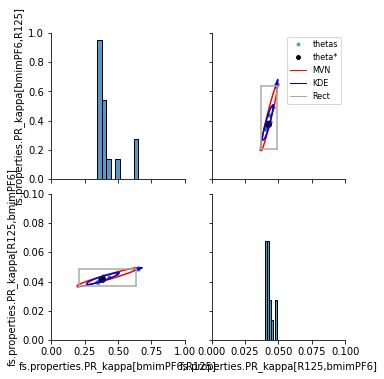

In [2]:
from R125_bmimPF6_PR import configuration

binary_params_peng2('R125IL298.csv', configuration, 'R125', 'bmimPF6', "x_R125", "x_bmimPF6", 
    init_temp = 298.15, init_press = 799600, init_x_c1 = 0.739, init_x_c2 = 0.261,
    init_kappa_2_1 = 0.1, init_kappa_1_2 = 0.07, eps = 0.1, scaling_fac = 1e-9)